# 루브릭
|평가문항|상세기준|self check|
|:-------|:-------|:-----------------------|
|1. 데이터의 전처리 및 구성과정이 체계적으로 진행되었는가?|특수문자 제거, 토크나이저 생성, 패딩 처리의 작업들이 빠짐없이 진행되었는가?|OK|
|2. 가사 텍스트 생성 모델이 정상적으로 동작하는가?|텍스트 제너레이션 결과로 생성된 문장이 해석 가능한 문장인가?|OK|
|3. 텍스트 생성모델이 안정적으로 학습되었는가?|텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?|OK|


### dataset
1. lyrics 폴더안의 6.5Mb 텍스트 파일


### 적용할 알고리즘
1. RNN(Recurrent Neural Network) + LSTM(Long Short Term Memory)

### 성능 평가 지표  
1. validation loss


## 문제 정의  

> RNN + LSTM 알고리즘으로 가사 텍스트 생성기 만들기   
> 성능 평가 지표 validation loss 2.2 이하로 낮주기

## 분석 결과  
 
|Metrics|RNN+LSTM| 
|---------|----------|
|validation loss|1.87|


## 분석환경

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Image

import glob  #glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import tensorflow

print(tensorflow.__version__)

2.6.0


## Step 1. 데이터 다운로드

In [8]:
# re: Regular Expression의 줄임말로, 파이썬 정규표현식을 사용하기 위한 모듈
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# tensorflow(TensorFlow): 데이터 흐름 프로그래밍을 위한 라이브러리. 데이터 그래프를 수치적으로 연산하기 위해 구글에서 만든 오픈 소스 라이브러리.
import re 
import numpy as np
import tensorflow as tf

## Step 2. 데이터 읽어오기

In [27]:
import glob
import os

txt_file_path = os.getenv('HOME') + '/data/lyrics/*' #os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장

txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r",encoding='utf8') as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:10])
#raw_corpus

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]', 'You ever want something ', "that you know you shouldn't have ", "The more you know you shouldn't have it, ", 'The more you want it ', 'And then one day you get it, ', "It's so good too ", "But it's just like my girl "]


## Step 3. 데이터 정제

1. preprocess_sentence() 함수 이용
2. (권장) 토큰 개수가 15개 넘어가는 문장 학습데이터에서 제외
 *  '< start >, < end >' 도 포함되어 있어서 max_len = 20 초과 시에 학습 데이터에서 제외했음

In [10]:
# enumerate() 함수를 이용하여 raw_corpus list 내에 저장된 문장과 그 문장의 인덱스를 반환 (인덱스, 문장 순)
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 10: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

[Spoken Intro:]
You ever want something 
that you know you shouldn't have 
The more you know you shouldn't have it, 
The more you want it 
And then one day you get it, 
It's so good too 
But it's just like my girl 
When she's around me 


In [11]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [12]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> spoken intro <end>',
 '<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>']

* tf.keras.preprocessing.text.Tokenizer

In [14]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)   
 
    # 20 단어 초과 시에 삭제
    print(len(tensor))
    max_len = 0
    for i,j in enumerate(tensor):
        #if len(j) > 15:
        if len(j) > 20:
            #print(i,j) 
            del tensor[i]
            #print("delete",tensor[i])
        else:
            if max_len < len(j):
                max_len = len(j)
                
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=max_len)  
    
    #print(tokenizer.word_index)
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)
tensor.shape

175749
[[   2 2701 2584 ...    0    0    0]
 [   2    7  156 ...    0    0    0]
 [   2   17    7 ...    0    0    0]
 ...
 [   2  311    1 ...    0    0    0]
 [   2  735    5 ...    0    0    0]
 [   2  735    5 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f8a08b51a00>


(169989, 20)

In [16]:
print(tensor[:3, :10])

[[   2 2701 2584    3    0    0    0    0    0    0]
 [   2    7  156   62  199    3    0    0    0    0]
 [   2   17    7   34    7 1518   15   76    3    0]]


* tokenizer에 구축된 단어 사전의 인덱스

In [29]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형대로 반환 (Ex. {index: '~~', index: '~~', ...})
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

        
print(f"\n총단어수 : {tokenizer.document_count}")
#print(f"\n단어빈도수 : {tokenizer.word_counts}")
#tokenizer.word_counts
#tokenizer.word_docs

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to

총단어수 : 175749


* Source Sentence과 Target Sentence 생성 

In [94]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[1])
print(tgt_input[1])

[  2   7 156  62 199   3   0   0   0   0   0   0   0   0   0   0   0   0
   0]
[  7 156  62 199   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]


## Step 4. 평가 데이터셋 분리

1. 훈련 데이터와 평가 데이터를 분리
  * tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_split() 함수를 사용.
  * 총 데이터의 20% 를 평가 데이터셋으로 사용 
2. 단어장의 크기는 12,000 이상 으로 설정
 

In [95]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,tgt_input , 
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=2023)


In [96]:
print('source_train: ', enc_train.shape)
print('source_validation: ', enc_val.shape)
print('target_train: ', dec_train.shape)
print('target_validation: ', dec_val.shape)

source_train:  (135991, 19)
source_validation:  (33998, 19)
target_train:  (135991, 19)
target_validation:  (33998, 19)


## Step 5. 인공지능 만들기

1. 모델 설계
 * 10 Epoch 안에 val_loss값 2.2 이하 수준
 * Embedding Size, Hidden Size 조절
 * model.fit()함수의 parameter 변경

* 단어장 크기

In [97]:
tokenizer.num_words

12000

In [24]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   
embedding_size = 20 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 1024*3 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.


In [25]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다
#Loss : tf.keras.losses.SparseCategoricalCrossentropy : https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

# Adam 알고리즘을 구현하는 optimzier이며 어떤 optimzier를 써야할지 모른다면 Adam을 쓰는 것도 방법이다.
# 우리가 학습을 할 때 최대한 틀리지 않는 방향으로 학습을 해야한다.
# 여기서 얼마나 틀리는지(loss)를 알게하는 함수가 손실함수 이다.
# 이 손실함수의 최소값을 찾는 것을 학습의 목표로 하며 여기서 최소값을 찾아가는 과정을 optimization 이라하고
# 이를 수행하는 알고리즘을 optimizer(최적화)라고 한다.

optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.

In [101]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

#학습의 조기 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
#모델 학습 
# fit : https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
history = model.fit(x=enc_train,y=dec_train,validation_data=(enc_val,dec_val) ,epochs=10, batch_size=512, callbacks=[early_stopping_callback])

Epoch 1/10
266/266 [==============================] - 735s 3s/step - loss: 3.0059 - val_loss: 2.6043
Epoch 2/10
266/266 [==============================] - 680s 3s/step - loss: 2.4599 - val_loss: 2.3993
Epoch 3/10
266/266 [==============================] - 682s 3s/step - loss: 2.2777 - val_loss: 2.2582
Epoch 4/10
266/266 [==============================] - 679s 3s/step - loss: 2.0978 - val_loss: 2.1473
Epoch 5/10
266/266 [==============================] - 678s 3s/step - loss: 1.9068 - val_loss: 2.0530
Epoch 6/10
266/266 [==============================] - 679s 3s/step - loss: 1.7081 - val_loss: 1.9800
Epoch 7/10
266/266 [==============================] - 679s 3s/step - loss: 1.5183 - val_loss: 1.9254
Epoch 8/10
266/266 [==============================] - 680s 3s/step - loss: 1.3516 - val_loss: 1.8897
Epoch 9/10
266/266 [==============================] - 679s 3s/step - loss: 1.2132 - val_loss: 1.8720
Epoch 10/10
266/266 [==============================] - 678s 3s/step - loss: 1.1048 - val_lo

In [102]:
# 모델의 구조 확인
model.summary()

Model: "text_generator_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      multiple                  240020    
_________________________________________________________________
lstm_6 (LSTM)                multiple                  38006784  
_________________________________________________________________
lstm_7 (LSTM)                multiple                  75509760  
_________________________________________________________________
dense_3 (Dense)              multiple                  36879073  
Total params: 150,635,637
Trainable params: 150,635,637
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 0, 'epoch')

Text(0, 0.5, 'loss')

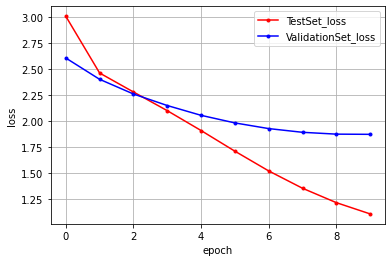

In [103]:
import matplotlib.pyplot as plt

# 검증셋과 학습셋의 오차를 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, marker='.', c="red", label='TestSet_loss')
plt.plot(x_len, y_vloss, marker='.', c="blue", label='ValidationSet_loss')

# 그래프에 그리드를 주고 레이블 표시.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

마지막으로 멋진 모델이 생성한 가사 한 줄을 제출

In [89]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [104]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)
# generate_text 함수에 lyricist 라 정의한 모델을 이용해서 ilove 로 시작되는 문장을 생성

'<start> i love you so much , i love you so much , i love you so much <end> '

## 회고

* 모델 최적화를 위해 파마미터값을 다양하게 바꿔가며 시도해 보고 싶었지만, 모델 학습 시에 시간이 너무 많이 걸려서 많이 해보지 못함
* 처음에 embedding size (단어의 추상적인 특징을 나타내는 벡터 크기)가 켜야 성능이 좋아질거라고 생각해서, size를 점진적으로 늘리는 시도를 해서 시간을 많이 소비함. 
* 학습 데이터 크기의 중요성을 느꼈음
  * 15개 문장 이하만 학습 시, val_loss가 2.2 이하로 떨어지지 않았음
  * 17개 문장 이상으로 학습 시, val_loss가  2.2 이하로 떨어짐
  * 최종 설계는 20개 문장 이하로 학습 시켜서, val_loss 1.87 까지 낮춤 

## 참고문헌
* [모두의 딥러닝 개정3판](https://thebook.io/080324/)